In [83]:
#bibliotecas necesarias para el funcionamiento
import pandas                  as pd                     #manejo y manipulación de dataframes
import scipy
import numpy                   as np                     #soporte matricial y vectorial
import matplotlib.pyplot       as plt                    #graficos
import joblib
from   sklearn.model_selection import GridSearchCV       #optimización de hiperparametros
from   sklearn                 import metrics            #metricas de validación
from   sklearn.model_selection import train_test_split   #segmentación de muestra
from   sklearn.linear_model    import LogisticRegression #clasificador 
from   sklearn.impute          import SimpleImputer      
from   sklearn.compose         import ColumnTransformer
from   sklearn.pipeline        import Pipeline
from   sklearn.preprocessing   import LabelEncoder
from   sklearn.preprocessing   import OneHotEncoder,StandardScaler
from   sklearn.preprocessing   import KBinsDiscretizer
from   sklearn.metrics         import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from sklearn import svm
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn import datasets
from   sklearn.model_selection import train_test_split
from sklearn import metrics



import pandas as pd
url = "C:/Users/David Guzman/OneDrive/Documentos/7mo Semestre/Seminario Estadistica/covid.csv"
data = pd.read_csv(url,engine='python', index_col=0)
data=data[0:7000]

#columnas con las covariables que se van a seleccionar del modelo
columnas=["SEXO","OBESIDAD","DIABETES","EPOC","ASMA","CARDIOVASCULAR","RENAL CRONICA","INMUNOSUPRESION","HIPERTENSION","TIPO PACIENTE","EDAD"]

In [84]:
#Nos quedamos unicamente con los positivos
filelocal="C:/Users/David Guzman/OneDrive/Documentos/7mo Semestre/Seminario Estadistica/covid.csv"
def getData(file,columnas,filtro="positivo"):
    df=pd.read_csv(file,header=0,sep=",",encoding='utf-8',low_memory=False)
    df=df.loc[1:7000,columnas]
    print("casos totales")
    print(df.shape)
    return df  

In [85]:
#quitamos aquellos datos donde se ignora la condicion
def limpiaData(data,feature,conditions):
    df=data
    for i in feature:
        df = df.drop(df[(df[i] == conditions)].index)
    print("datos finales "+str(df.shape))    
    return df

In [86]:
df=getData(filelocal,columnas) 
feat=['OBESIDAD','DIABETES','EPOC','ASMA',"CARDIOVASCULAR",'RENAL CRONICA',"INMUNOSUPRESION","HIPERTENSION"]

casos totales
(7000, 11)


In [87]:
df=limpiaData(df,feat,'SE IGNORA')
df=df.query("EDAD<100")
df.to_csv("covidfilter.csv")

datos finales (7000, 11)


In [88]:
#proporción de pacientes ambulatorios y hospitalizados
df["TIPO PACIENTE"].value_counts()

AMBULATORIO      4620
HOSPITALIZADO    2379
Name: TIPO PACIENTE, dtype: int64

In [89]:
y=LabelEncoder().fit_transform(df["TIPO PACIENTE"])
X=df.drop(["TIPO PACIENTE"],axis=1)
X.head(1)

,SEXO,OBESIDAD,DIABETES,EPOC,ASMA,CARDIOVASCULAR,RENAL CRONICA,INMUNOSUPRESION,HIPERTENSION,EDAD
1,MUJER,NO,NO,NO,NO,NO,NO,NO,NO,37


In [90]:
#Modleo: Crea un pipeline para generar el modelo
def modelo(X_train, y_train,numeric_features,categorical_features):
    numeric_transformer = Pipeline(steps=[
    ('imputer', KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile'))])
    categorical_transformer = Pipeline(steps=[
        #imputacion por el valor más frecuente
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    #onehot encoder para las varibales categoricas    
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
    #el pipeline con el procesamienot y el claificador
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', gridsearh())])
    modelo=clf.fit(X_train, y_train)
    return modelo

In [91]:
#GRID SEARCH: Prueba con varios modelos usando holdout 70-30
def gridsearh():
    clf = LogisticRegression(fit_intercept=True,solver='lbfgs',tol=1e-5,max_iter=75,n_jobs=8)
    grid_values = {'penalty': [ 'l2'],'C':np.logspace(-5, 5, 100)}
    """se evalúan todas las combinaciones posibles de valores de parámetros y 
    se conserva la mejor combinacion."""   
    grid_clf_acc = GridSearchCV(clf, param_grid = grid_values,scoring = 'accuracy')
    return grid_clf_acc

In [92]:
#El score obtenido con el modelo de regresión logistica
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
categorical_features = ['SEXO','OBESIDAD','DIABETES','EPOC','ASMA','CARDIOVASCULAR','RENAL CRONICA',"INMUNOSUPRESION","HIPERTENSION"]
numeric_features=['EDAD']
modelo=modelo(X_train, y_train,numeric_features,categorical_features)
print("model score: %.3f" % modelo.score(X_test, y_test))

model score: 0.735


In [93]:
#Se imprimen los coeficientes asociados a los estimadores
print(modelo.named_steps['classifier'].best_estimator_.coef_)
print(modelo.named_steps['classifier'].best_estimator_.intercept_)

[[ 0.58386188  0.24638579 -0.2466192  -0.06934639  0.06911297 -0.29555411
   0.29532069 -0.14921216  0.14897875  0.05986339 -0.0600968  -0.14649964
   0.14626622 -0.64366092  0.64342751 -0.20064783  0.20041441 -0.24642364
   0.24619022]]
[-0.65195593]


In [94]:
print(modelo.named_steps['classifier'].best_estimator_)

LogisticRegression(C=0.13848863713938717, max_iter=75, n_jobs=8, tol=1e-05)


In [95]:
#la matriz de confusion
predict=modelo.predict(X_test)
cm = metrics.confusion_matrix(y_test, predict)
print(cm) 

[[1169  199]
 [ 358  374]]


array([[0.76555337, 0.34729494],
       [0.23444663, 0.65270506]])

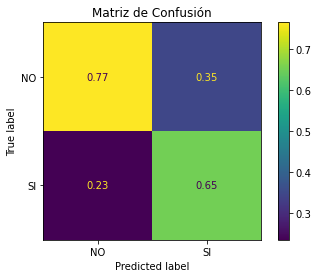

In [96]:
#la matriz de confusion en scikit learn normaalizado
disp=metrics.plot_confusion_matrix(modelo, X_test, y_test,normalize="pred",display_labels=np.array(["NO","SI"]))
disp.ax_.set_title("Matriz de Confusión")
disp.confusion_matrix

In [97]:
#calculo de las probabilidades y el AUC
probs = modelo.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

In [98]:
predictions=modelo.predict(X_test)
print('Accuracy score: ', format(accuracy_score(y_test, predictions)))
print('Precision score: ', format(precision_score(y_test, predictions)))
print('Recall score: ', format(recall_score(y_test, predictions)))
print('F1 score: ', format(f1_score(y_test, predictions)))

Accuracy score:  0.7347619047619047
Precision score:  0.6527050610820244
Recall score:  0.5109289617486339
F1 score:  0.5731800766283525


(array([168., 312., 351.,  38., 177., 156.,  15., 225.,  78.,  19., 216.,
         74.,  26., 128.,  42.,  45.,   7.,  12.,  11.]),
 array([0.06238488, 0.10933081, 0.15627673, 0.20322266, 0.25016858,
        0.29711451, 0.34406043, 0.39100636, 0.43795229, 0.48489821,
        0.53184414, 0.57879006, 0.62573599, 0.67268192, 0.71962784,
        0.76657377, 0.81351969, 0.86046562, 0.90741155, 0.95435747]),
 <a list of 19 Patch objects>)

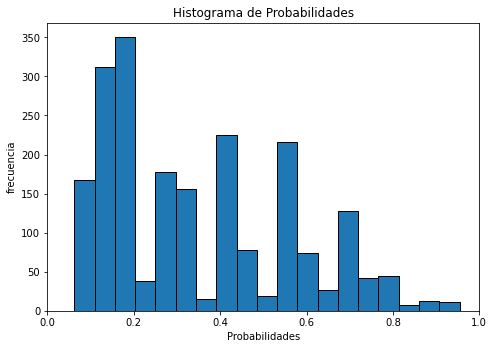

In [99]:
fig=plt.figure()
axes=fig.add_axes([1,1,1.0,1.0])
axes.set_title("Histograma de Probabilidades")
axes.set_xlim(0,1)
axes.set_xlabel("Probabilidades")
axes.set_ylabel("frecuencia")
axes.hist(preds,bins=19,edgecolor="black")

(0.0, 1.0)

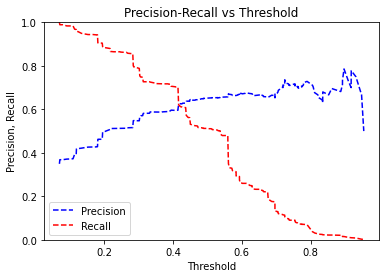

In [100]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, probs[:,1]) 
pr_auc = metrics.auc(recall, precision)
plt.title("Precision-Recall vs Threshold")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

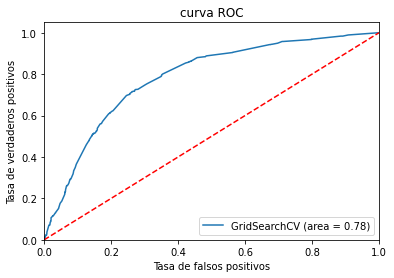

In [101]:
plt.figure()
plt.plot(fpr, tpr, label='GridSearchCV (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('curva ROC')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [102]:
#APLICAMOS ONEHOTENCODER Y AJUSTAMOS EL KERNEL LINEAL PARA 5000 datos 
data

,SEXO,OBESIDAD,DIABETES,EPOC,ASMA,CARDIOVASCULAR,RENAL CRONICA,INMUNOSUPRESION,HIPERTENSION,TIPO PACIENTE,EDAD
0,MUJER,NO,NO,NO,NO,NO,NO,NO,NO,AMBULATORIO,51
1,MUJER,NO,NO,NO,NO,NO,NO,NO,NO,AMBULATORIO,37
2,HOMBRE,NO,NO,NO,NO,NO,NO,NO,NO,AMBULATORIO,18
3,HOMBRE,NO,NO,NO,NO,NO,NO,NO,NO,AMBULATORIO,40
4,MUJER,NO,SI,NO,NO,NO,SI,NO,SI,HOSPITALIZADO,78
...,...,...,...,...,...,...,...,...,...,...,...
7033,MUJER,SI,SI,NO,NO,NO,NO,NO,NO,AMBULATORIO,55
7034,MUJER,NO,SI,NO,NO,NO,NO,NO,NO,AMBULATORIO,33
7035,HOMBRE,NO,NO,NO,NO,NO,NO,NO,NO,AMBULATORIO,22
7036,HOMBRE,NO,SI,NO,NO,NO,NO,NO,NO,AMBULATORIO,35


In [103]:
#hacemos variables dummies a todas las variables categoricas
sexo_dummy=pd.get_dummies(data["SEXO"], prefix="SEXO")
obesidad_dummy=pd.get_dummies(data["OBESIDAD"], prefix="OBESIDAD")
diabetes_dummy=pd.get_dummies(data["DIABETES"], prefix="DIABETES")
epoc_dummy=pd.get_dummies(data["EPOC"], prefix="EPOC")
asma_dummy=pd.get_dummies(data["ASMA"], prefix="ASMA")
cardiovascular_dummy=pd.get_dummies(data["CARDIOVASCULAR"], prefix="CARDIOVASCULAR")
renalcro_dummy=pd.get_dummies(data["RENAL CRONICA"], prefix="RENAL CRONICA")
inmunosupresion_dummy=pd.get_dummies(data["INMUNOSUPRESION"], prefix="INMUNOSUPRESION")
hipertension_dummy=pd.get_dummies(data["HIPERTENSION"], prefix="HIPERTENSION")
tipopaciente_dummy=pd.get_dummies(data["TIPO PACIENTE"], prefix="TIPO PACIENTE")

In [104]:
data=pd.concat([data,sexo_dummy ], axis=1)
data=pd.concat([data,obesidad_dummy], axis=1)
data=pd.concat([data,diabetes_dummy], axis=1)
data=pd.concat([data,epoc_dummy], axis=1)
data=pd.concat([data,asma_dummy], axis=1)
data=pd.concat([data,cardiovascular_dummy], axis=1)
data=pd.concat([data,renalcro_dummy], axis=1)
data=pd.concat([data,inmunosupresion_dummy], axis=1)
data=pd.concat([data,hipertension_dummy], axis=1)
data=pd.concat([data,tipopaciente_dummy], axis=1)

In [105]:
data_dummies=data.drop(data.columns[[0,1,2,3,4,5,6,7,8,9]], axis=1)
data_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 0 to 7037
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   EDAD                         7000 non-null   int64
 1   SEXO_HOMBRE                  7000 non-null   uint8
 2   SEXO_MUJER                   7000 non-null   uint8
 3   OBESIDAD_NO                  7000 non-null   uint8
 4   OBESIDAD_SI                  7000 non-null   uint8
 5   DIABETES_NO                  7000 non-null   uint8
 6   DIABETES_SI                  7000 non-null   uint8
 7   EPOC_NO                      7000 non-null   uint8
 8   EPOC_SI                      7000 non-null   uint8
 9   ASMA_NO                      7000 non-null   uint8
 10  ASMA_SI                      7000 non-null   uint8
 11  CARDIOVASCULAR_NO            7000 non-null   uint8
 12  CARDIOVASCULAR_SI            7000 non-null   uint8
 13  RENAL CRONICA_NO             7000 non-null   uin

In [106]:
#Variable target 
Y=pd.Categorical(data['TIPO PACIENTE']).codes
X=data_dummies.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]]

train_X, test_X, train_Y, test_Y = train_test_split (X.values, Y, test_size = 0.2)
modelo = svm.SVC(C = 1.0, kernel = 'linear')
modelo.fit(train_X, train_Y)



# Evaluamos su rendimiento predictivo en el conjunto de entrenamiento:
predictions = modelo.predict(train_X)
print((predictions==train_Y).mean())

0.7360714285714286


In [107]:
#Evaluamos su desempeño en el conjunto de prueba
predictions = modelo.predict(test_X)
print((predictions==test_Y).mean())

0.7435714285714285
